# Cassandra driver.

Query Cassandra database to get activations for pages exported from Neo4J in a CSV file.

In [1]:
from cassandra.cluster import Cluster
from cassandra.cluster import ExecutionProfile
from cassandra.auth import PlainTextAuthProvider
from cassandra import query
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
import json

In [2]:
plt.style.use('dark_background')
from pylab import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']
rcParams['xtick.labelsize'] = 25
rcParams['ytick.labelsize'] = 25
rcParams['axes.labelsize'] = 35
rcParams['legend.fontsize'] = 25

Read ids from CSV

In [3]:
pages_df = pd.read_csv('./data/got_characters.csv')

In [4]:
pages_df.head()

,p.id,p.title
0,43880486,High_Sparrow
1,152995,Kenny_McCormick
2,1289409,Roose_Bolton
3,976141,Jon_Snow_(character)
4,978301,Robb_Stark


Prepare Cassandra connection

Create `config.ini` and specify your credentials.

`config.ini` content should be as follows:

```
[cassandraDB]
host = IP
user = USER_NAME
pass = PASSWORD
```

Use your Cassandra `IP`, `USER_NAME`, and `PASSWORD`.

In [5]:
import configparser
config = configparser.ConfigParser()
config.read('config.ini')

['config.ini']

In [6]:
auth_provider = PlainTextAuthProvider(
        username=config['cassandraDB']['user'], password=config['cassandraDB']['pass'])
# execution_profile = ExecutionProfile(request_timeout=3600, row_factory=pandas_factory)
# profiles = {'node1': execution_profile}

In [7]:
cluster = Cluster([config['cassandraDB']['host']], auth_provider=auth_provider, port=9042)

In [8]:
session = cluster.connect()

In [9]:
session.default_timeout = 3600

In [10]:
session.set_keyspace("wikipedia")

In [11]:
def pandas_factory(colnames, rows):
    return pd.DataFrame(rows, columns=colnames)

In [12]:
session.row_factory = pandas_factory

In [13]:
session.default_fetch_size = 10000000 #needed for large queries, otherwise driver will do pagination. Default is 50000.

Query Cassandra

In [14]:
start_time = "2018-11-01 00:00:00"
end_time = "2018-11-15 00:00:00"
ids_list_string = str(tuple(pages_df["p.id"].values))

In [22]:
#NOTE: this query is time-consuming. Update cassandra.yaml `read_request_timeout_in_ms` to 50000 ms and `range_request_timeout_in_ms` to 10000
rows = session.execute("SELECT * FROM wikipedia.page_visits WHERE page_id IN " + ids_list_string + " AND visit_time >='" + start_time + "' AND visit_time <='" + end_time + "'")

In [23]:
rows_df = rows._current_rows

In [24]:
rows_df.shape

(13652, 3)

In [25]:
rows_df.head()

,page_id,visit_time,count
0,152995,2018-10-31 23:00:00,10
1,152995,2018-11-01 00:00:00,6
2,152995,2018-11-01 01:00:00,12
3,152995,2018-11-01 02:00:00,17
4,152995,2018-11-01 03:00:00,9


In [26]:
# replace page IDs with page titles
rows_df = pd.merge(rows_df,pages_df, how='left', left_on=['page_id'], right_on = ['p.id']).drop(columns=['p.id', 'page_id'])

In [27]:
rows_df.head()

,visit_time,count,p.title
0,2018-10-31 23:00:00,10,Kenny_McCormick
1,2018-11-01 00:00:00,6,Kenny_McCormick
2,2018-11-01 01:00:00,12,Kenny_McCormick
3,2018-11-01 02:00:00,17,Kenny_McCormick
4,2018-11-01 03:00:00,9,Kenny_McCormick


Groupby to plot

In [28]:
rows_df.set_index('visit_time', inplace=True)
rows_df = rows_df.loc[rows_df['p.title'].isin(['Daenerys_Targaryen', 'Arya_Stark'])].groupby('p.title')

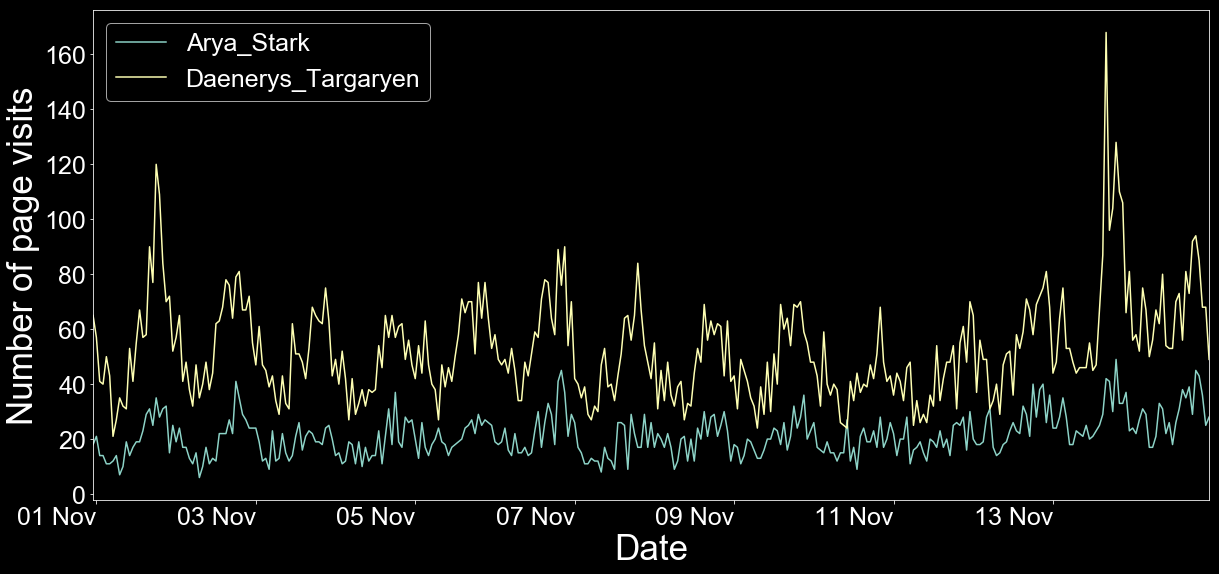

In [29]:
fig, ax = plt.subplots(figsize = (20,10))
rows_df['count'].plot(legend=True, x_compat=True)
plt.xlabel("Date")
plt.ylabel("Number of page visits")
plt.setp(ax.get_xticklabels(), rotation=0)
ax.xaxis.set_major_formatter(
    mdates.DateFormatter('%d %b')
)
# plt.savefig("timeseries.pdf", format="PDF", bbox_inches='tight')